In [1]:
import os

datapath = os.getcwd()+'\\data'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
TrainData = pd.read_csv(datapath + './train.csv')
ValData = pd.read_csv(datapath + './val.csv')
TestData = pd.read_csv(datapath + './test.csv')

In [4]:
val_normal, val_fraud = ValData['Class'].value_counts()
val_contamination = val_fraud / val_normal

print('prob :',val_contamination)

prob : 0.0010551491277433877


In [5]:
train_x = TrainData.drop(columns=['ID'])

-----------------------------------------------

EllipticEnvelope 기반

In [6]:
model_EE = EllipticEnvelope(support_fraction = 0.994, contamination = val_contamination, random_state = 42)
model_EE.fit(train_x)

EllipticEnvelope(contamination=0.0010551491277433877, random_state=42,
                 support_fraction=0.994)

In [7]:
def get_pred_label(model, x, k): #스코어 순으로 정렬하여 가장 우선순위가 높은 샘플 추출
  score = model.score_samples(x)
  score = pd.DataFrame(score,columns=['score'])
  li_sc = list(score.sort_values(by='score')[:k].index)

  pred = np.zeros(len(x), dtype = int)
  pred[li_sc] = 1
  return pred.tolist(), score['score'].tolist()

In [8]:
val_x = ValData.drop(columns=['ID', 'Class']) # Input Data
val_y = ValData['Class'] # Label

val_pred, val_prob = get_pred_label(model_EE, val_x, 29)

pred_1 = pd.DataFrame(val_pred, columns=['pred_1']) #결과 저장

val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

tn, fn, fp, tp = confusion_matrix(val_y, val_pred).ravel()
print('tp : ', tp, ', fp : ', fp, ', tn : ', tn, ', fn : ', fn)

Validation F1 Score : [0.9236496787663914]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.83      0.85        30

    accuracy                           1.00     28462
   macro avg       0.93      0.92      0.92     28462
weighted avg       1.00      1.00      1.00     28462

tp :  25 , fp :  5 , tn :  28428 , fn :  4


-----------------------------------------------

### KDE기반

검증용 kde

In [9]:
from scipy.stats import gaussian_kde

cols = TrainData.columns[1:]

val_pdf = pd.DataFrame() 

#사기일 KDF

for col in cols :
    v_data = ValData[ValData['Class']==1][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(ValData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    val_pdf = pd.concat([val_pdf,pdf_V], axis = 1)

In [10]:
val_pdf_zero = pd.DataFrame()

#사기가 아닐 KDF

for col in cols :
    v_data = ValData[ValData['Class']==0][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(ValData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    val_pdf_zero = pd.concat([val_pdf_zero,pdf_V], axis = 1)

In [11]:
#정규화

from sklearn.preprocessing import MinMaxScaler

scaler_one = MinMaxScaler()
val_pdf_mm = scaler_one.fit_transform(val_pdf)
val_pdf_mm=pd.DataFrame(val_pdf_mm,columns=val_pdf.columns)

scaler_zero = MinMaxScaler()
val_pdf_zero_mm =scaler_zero.fit_transform(val_pdf_zero)
val_pdf_zero_mm=pd.DataFrame(val_pdf_zero_mm,columns=val_pdf_zero.columns)

In [12]:
score_val = val_pdf_mm - val_pdf_zero_mm
v_score = score_val.T.sum()

In [13]:
v_score = pd.DataFrame(v_score,columns=['score'])
score_class = pd.concat([ValData,v_score],axis=1)

score_class = score_class.sort_values(by='score', ascending=False).reset_index(drop=True)

faud_ID = score_class['ID'][:27]

id_ind =[]

for fid in faud_ID :
    id_ind = id_ind + list(ValData[ValData['ID'] == fid].index)

In [14]:
val_pred = np.zeros(len(ValData), dtype = int)
val_pred[id_ind] = 1


pred_2 = pd.DataFrame(val_pred, columns=['pred_2']) #결과 저장

val_x = ValData.drop(columns=['ID', 'Class']) # Input Data
val_y = ValData['Class'] # Label

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#val_pred = model.predict(val_x) # model prediction
#val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')

print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

tn, fn, fp, tp = confusion_matrix(val_y, val_pred).ravel()
print('tp : ', tp, ', fp : ', fp, ', tn : ', tn, ', fn : ', fn)

Validation F1 Score : [0.956096388649539]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.96      0.87      0.91        30

    accuracy                           1.00     28462
   macro avg       0.98      0.93      0.96     28462
weighted avg       1.00      1.00      1.00     28462

tp :  26 , fp :  4 , tn :  28431 , fn :  1


In [15]:
result_val = pd.concat([ValData[['ID', 'Class']],pred_1,pred_2],axis=1)

In [121]:
green_val = list(result_val[(result_val['pred_2']==1)&(result_val['Class']==1)].index)
red_val = list(result_val[(result_val['pred_2']==0)&(result_val['Class']==1)].index)

데이터 확인

In [67]:
import math

root = len(TrainData.drop(columns=['ID']).columns)**0.5
nrows = math.floor(root)
ncols = math.ceil(root)

arr = np.ones((nrows, ncols))

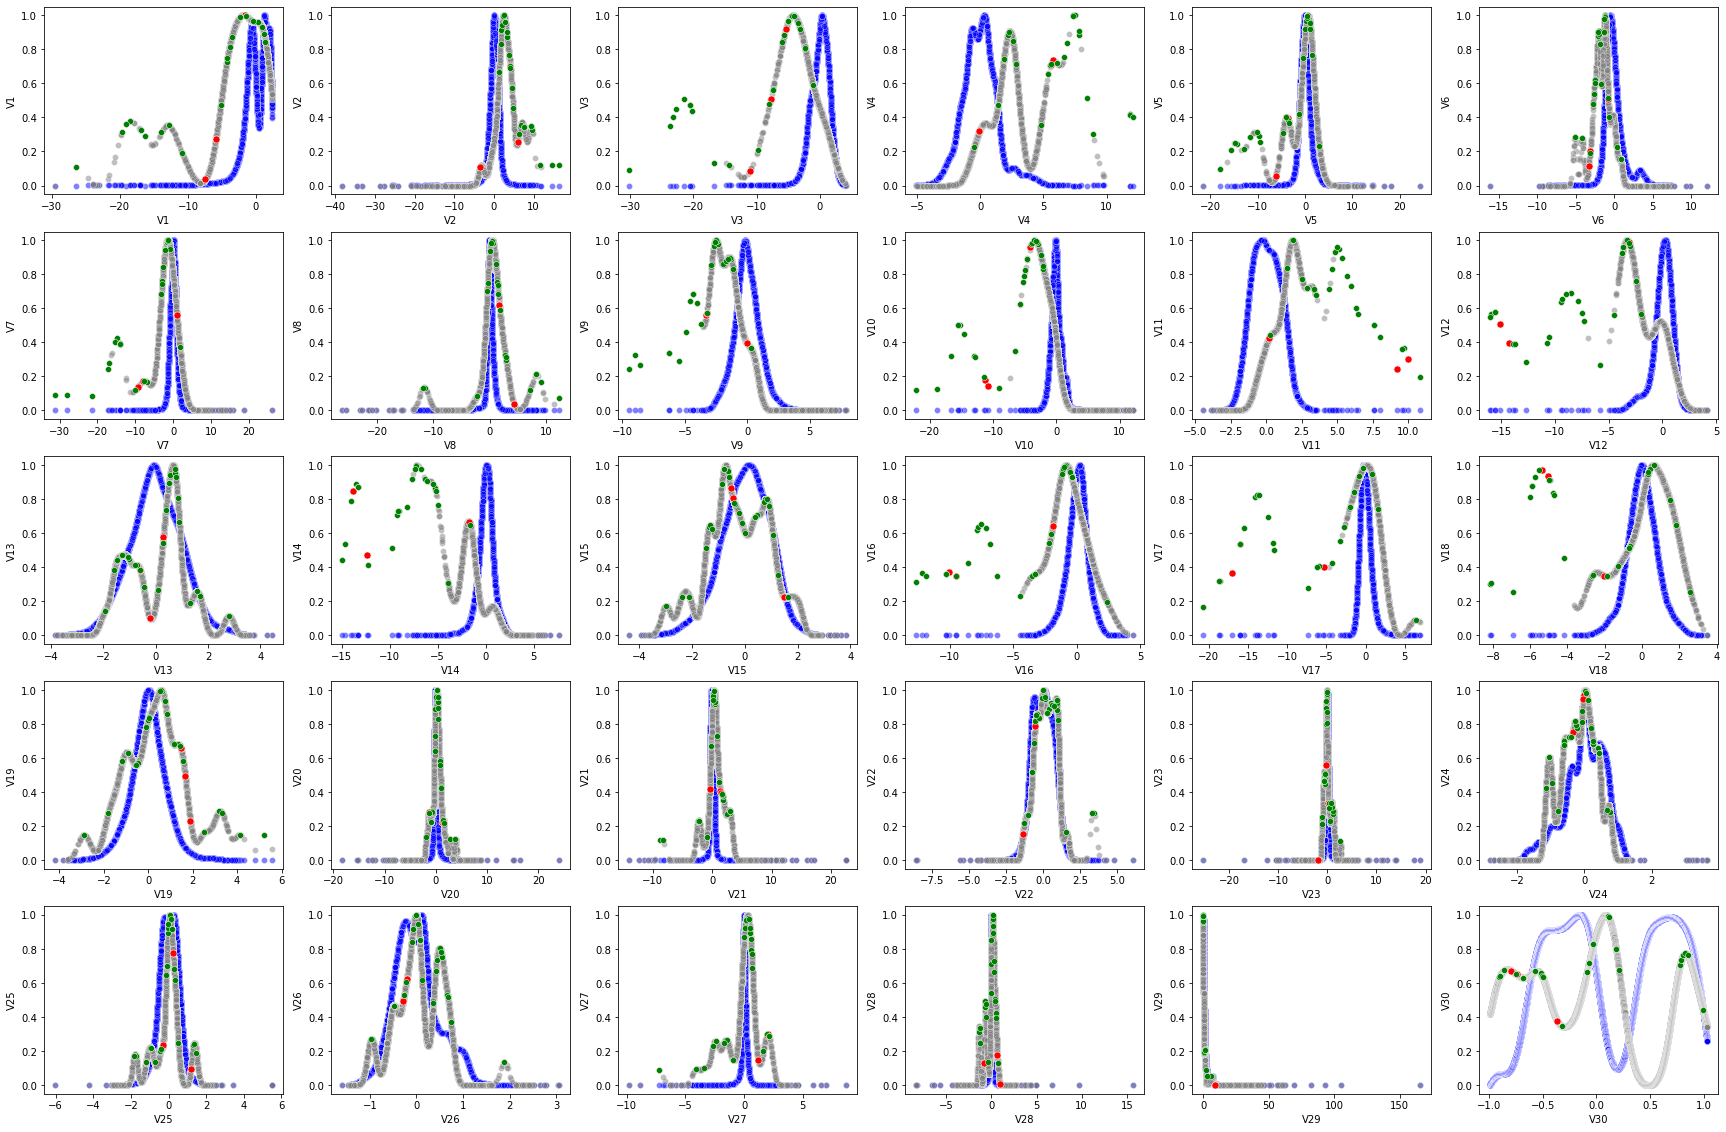

In [124]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.scatterplot(x=ValData[col],y=val_pdf_zero_mm[col], ax = axes[i,j], color = 'blue', alpha=0.5,)
    sns.scatterplot(x=ValData[col],y=val_pdf_mm[col], ax = axes[i,j], color = 'gray', alpha=0.5,) #-val_pdf_zero[col]
    sns.scatterplot(x=list(ValData[col][[1047,1210,7000]]),y=list(val_pdf_mm[col][[1047,1210,7000]]), ax = axes[i,j], color = 'red', s=50) #-val_pdf_zero[col][red_val]
    sns.scatterplot(x=list(ValData[col][green_val]),y=list(val_pdf_mm[col][green_val]), ax = axes[i,j], color = 'green') #-val_pdf_zero[col][green_val]
 
plt.show()

-----------------------------------------------

## KDE 추정모델 개발

model test (keras)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

In [142]:
# model = keras.Sequential(
#     [
#         layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
#         layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Dropout(rate=0.2),
#         layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Dropout(rate=0.2),
#         layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
#     ]
# )
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.summary()

In [26]:
from sklearn.model_selection import train_test_split

# One_score = val_pdf_mm.T.sum()
# Zero_score = val_pdf_zero_mm .T.sum()

scaler_val = MinMaxScaler()
ValData_mm = scaler_val.fit_transform(ValData.drop(columns=['ID', 'Class']))
ValData_mm = pd.DataFrame(ValData_mm,columns=val_pdf.columns)


X_train, X_test, y_train, y_test = train_test_split(ValData.drop(columns=['ID', 'Class']), val_pdf_zero_mm, test_size=0.7, random_state=42)

In [23]:
from tensorflow.keras import losses
import tensorflow as tf

def rank_loss_fn(y_true, y_pred):
    import pandas as pd
    # y_true_ind = y_true.T.sum().sort_values(ascending=False)[:30].index
    # y_true = list(y_true.T.sum().sort_values(ascending=False)[:30])
    # y_pred = list(y_pred.T.sum().sort_values(ascending=False).loc[y_true_ind])

    y_true_ind = tf.argsort(tf.reduce_sum(y_true, axis=-1),direction = 'DESCENDING')[:30]
    y_true = tf.sort(tf.reduce_sum(y_true, axis=-1),direction = 'DESCENDING')[:30]
    y_pred = tf.gather(tf.reduce_sum(y_pred, axis=-1), indices=y_true_ind)

    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [19]:
model = keras.Sequential(
    [
        layers.Dense(256, activation="LeakyReLU", input_shape=(X_train.shape[1],)),
        layers.Dense(256, activation="LeakyReLU"),
        #layers.Dropout(0.1),
        layers.Dense(256, activation="LeakyReLU"),
        #layers.Dropout(0.1),
        layers.Dense(30, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 30)                7710      
                                                                 
Total params: 147,230
Trainable params: 147,230
Non-trainable params: 0
_________________________________________________________________


In [30]:
metrics = [
    keras.metrics.MeanSquaredError(name='mse'),
    keras.metrics.AUC(name='auc'),
    rank_loss_fn,
]
# class_weight = {0: weight_for_0, 1: weight_for_1}

In [33]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss= 'mse', metrics=metrics) #rank_loss_fn #metrics=metrics
model.fit(X_train, y_train, batch_size=2048, epochs=200, verbose=1, validation_data=(X_test, y_test))#class_weight=class_weight,

Epoch 1/200
5/5 [==============================] - 3s 352ms/step - loss: 0.0244 - mse: 0.0241 - auc: 0.9853 - rank_loss_fn: 0.9043 - val_loss: 0.0260 - val_mse: 0.0260 - val_auc: 0.9736 - val_rank_loss_fn: 1.5557
Epoch 2/200
5/5 [==============================] - 0s 107ms/step - loss: 0.0231 - mse: 0.0231 - auc: 0.9875 - rank_loss_fn: 1.0260 - val_loss: 0.0252 - val_mse: 0.0252 - val_auc: 0.9809 - val_rank_loss_fn: 0.5603
Epoch 3/200
5/5 [==============================] - 0s 108ms/step - loss: 0.0224 - mse: 0.0224 - auc: 0.9838 - rank_loss_fn: 1.1173 - val_loss: 0.0247 - val_mse: 0.0247 - val_auc: 0.9817 - val_rank_loss_fn: 1.3802
Epoch 4/200
5/5 [==============================] - 0s 105ms/step - loss: 0.0218 - mse: 0.0218 - auc: 0.9850 - rank_loss_fn: 0.8831 - val_loss: 0.0241 - val_mse: 0.0241 - val_auc: 0.9808 - val_rank_loss_fn: 0.6730
Epoch 5/200
5/5 [==============================] - 0s 104ms/step - loss: 0.0214 - mse: 0.0214 - auc: 0.9843 - rank_loss_fn: 0.7383 - val_loss: 0.023

In [34]:
val_pred = model.predict(X_test)
val_pred = pd.DataFrame(val_pred,index=y_test.index,columns=y_test.columns)

623/623 [==============================] - 2s 3ms/step


In [35]:
one_ind = ValData.loc[val_pred.index][ValData['Class']==1].index

In [36]:
from sklearn.metrics import r2_score, mean_squared_error

print('r2 :', r2_score(y_test,val_pred))
print('mse :', mean_squared_error(y_test,val_pred))
print("")
print('r2_1 :', r2_score(y_test.loc[one_ind],val_pred.loc[one_ind]))
print('mse_1 :', mean_squared_error(y_test.loc[one_ind],val_pred.loc[one_ind]))


r2 : 0.9160236363131244
mse : 0.007470086065713726

r2_1 : -0.0016131741145312462
mse_1 : 0.08755565973796278


In [37]:
y_test.loc[one_ind].T.sum()

13706    16.681221
24110    12.394933
15054     3.957655
15027     6.125772
1201      5.175963
25504    13.022263
15425     5.750985
836       4.553861
24742     7.256295
12377    13.958128
15030     5.376437
677       9.042936
14221    19.456771
4039     10.080681
9326     21.017969
1547      5.165357
7702      8.609876
3055      7.160160
641       8.446624
27998    13.252170
4267      6.134884
25042    10.493710
71       14.440546
12797    10.555585
15345     3.619256
dtype: float64

In [38]:
val_pred.loc[one_ind].T.sum()

13706    16.246714
24110    12.367173
15054     3.853011
15027     5.909272
1201      4.802328
25504    13.205963
15425     7.393977
836       8.460121
24742     9.522817
12377    15.572309
15030     5.477038
677      11.007089
14221    19.329964
4039     10.999071
9326     20.302126
1547      6.526501
7702     14.477386
3055     11.241128
641       9.349890
27998    15.553108
4267      6.203038
25042    11.920471
71       15.349423
12797    12.954639
15345     3.175523
dtype: float32

Train KDE 추정 모델 개발

In [39]:
from scipy.stats import gaussian_kde

cols = TrainData.columns[1:]

train_pdf = pd.DataFrame()

for col in cols :
    v_data = ValData[ValData['Class']==1][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.16)
    
    pdf_V = kde_sp.pdf(TrainData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    train_pdf = pd.concat([train_pdf,pdf_V], axis = 1)

In [40]:
train_pdf_zero = pd.DataFrame()

#사기가 아닐 KDF

for col in cols :
    v_data = ValData[ValData['Class']==0][col]
    kde_sp = gaussian_kde(v_data,bw_method=0.04)
    re_sp = gaussian_kde(kde_sp.resample(10000),bw_method='silverman') #리샘플링 표본을 반영
    
    pdf_V = re_sp.pdf(TrainData[col])
    pdf_V = pd.DataFrame(pdf_V,columns=[col])
    
    train_pdf_zero = pd.concat([train_pdf_zero,pdf_V], axis = 1)

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler_one = MinMaxScaler()
train_pdf_mm = scaler_one.fit_transform(train_pdf)
train_pdf_mm = pd.DataFrame(train_pdf_mm,columns=train_pdf.columns)

scaler_zero = MinMaxScaler()
train_pdf_zero_mm = scaler_zero.fit_transform(train_pdf_zero)
train_pdf_zero_mm = pd.DataFrame(train_pdf_zero_mm,columns=train_pdf_zero.columns)

In [42]:
# T_score는 훈련 후 계산해보자
score = train_pdf_mm - train_pdf_zero_mm
T_score = score.T.sum()

In [23]:
one_score = train_pdf_mm.T.sum()
zero_score = train_pdf_zero_mm.T.sum()

In [43]:
from tensorflow.keras import losses
import tensorflow as tf

def rank_loss_fn(y_true, y_pred):
    y_true_ind = tf.argsort(tf.reduce_sum(y_true, axis=-1),direction = 'DESCENDING')[:30]
    y_true = tf.sort(tf.reduce_sum(y_true, axis=-1),direction = 'DESCENDING')[:30]
    y_pred = tf.gather(tf.reduce_sum(y_pred, axis=-1), indices=y_true_ind)

    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [44]:
from tensorflow import keras
from tensorflow.keras import layers

metrics = [
    keras.metrics.MeanSquaredError(name='mse'),
    keras.metrics.AUC(name='auc'),
    rank_loss_fn,
]

model_one = keras.Sequential(
    [
        layers.Dense(256, activation="LeakyReLU", input_shape=(X_train.shape[1],)),
        layers.Dense(256, activation="LeakyReLU"),
        #layers.Dropout(0.1),
        layers.Dense(256, activation="LeakyReLU"),
        #layers.Dropout(0.1),
        layers.Dense(30, activation="sigmoid"),
    ]
)

model_zero = keras.Sequential(
    [
        layers.Dense(256, activation="LeakyReLU", input_shape=(X_train.shape[1],)),
        layers.Dense(256, activation="LeakyReLU"),
        #layers.Dropout(0.1),
        layers.Dense(256, activation="LeakyReLU"),
        #layers.Dropout(0.1),
        layers.Dense(30, activation="sigmoid"),
    ]
)

model_one.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               7936      
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 30)                7710      
                                                                 
Total params: 147,230
Trainable params: 147,230
Non-trainable params: 0
_________________________________________________________________


In [129]:
from sklearn.model_selection import train_test_split

# One_score = val_pdf_mm.T.sum()
# Zero_score = val_pdf_zero_mm .T.sum()

scaler_val = MinMaxScaler()
TrainData_mm = scaler_val.fit_transform(TrainData.drop(columns=['ID']))
TrainData_mm = pd.DataFrame(TrainData_mm,columns=val_pdf.columns)


X_train, X_test, y_train, y_test = train_test_split(TrainData.drop(columns=['ID']), train_pdf_mm, test_size=0.7, random_state=42)

In [130]:
model_one.compile(optimizer=keras.optimizers.Adam(0.001), loss= 'mse', metrics=metrics) #rank_loss_fn #metrics=metrics
model_one.fit(X_train, y_train, batch_size=4096, epochs=200, verbose=1, validation_data=(X_test, y_test))#class_weight=class_weight,

Epoch 1/200
9/9 [==============================] - 1s 71ms/step - loss: 0.0684 - mse: 0.0214 - auc: 0.9853 - rank_loss_fn: 4.3349 - val_loss: 0.0428 - val_mse: 0.0428 - val_auc: 0.9615 - val_rank_loss_fn: 2.8899
Epoch 2/200
9/9 [==============================] - 0s 48ms/step - loss: 0.0359 - mse: 0.0359 - auc: 0.9630 - rank_loss_fn: 1.5406 - val_loss: 0.0283 - val_mse: 0.0283 - val_auc: 0.9661 - val_rank_loss_fn: 1.9187
Epoch 3/200
9/9 [==============================] - 0s 46ms/step - loss: 0.0245 - mse: 0.0245 - auc: 0.9670 - rank_loss_fn: 1.4316 - val_loss: 0.0197 - val_mse: 0.0197 - val_auc: 0.9694 - val_rank_loss_fn: 1.3990
Epoch 4/200
9/9 [==============================] - 0s 48ms/step - loss: 0.0176 - mse: 0.0176 - auc: 0.9692 - rank_loss_fn: 1.0425 - val_loss: 0.0153 - val_mse: 0.0153 - val_auc: 0.9700 - val_rank_loss_fn: 1.6212
Epoch 5/200
9/9 [==============================] - 0s 50ms/step - loss: 0.0140 - mse: 0.0140 - auc: 0.9707 - rank_loss_fn: 1.1225 - val_loss: 0.0128 - v

In [118]:
X_train, X_test, y_train, y_test = train_test_split(TrainData.drop(columns=['ID']), train_pdf_zero_mm, test_size=0.7, random_state=42)

In [119]:
model_zero.compile(optimizer=keras.optimizers.Adam(0.001), loss= 'mse', metrics=metrics) #rank_loss_fn #metrics=metrics
model_zero.fit(X_train, y_train, batch_size=4096, epochs=200, verbose=2, validation_data=(X_test, y_test))#class_weight=class_weight,

Epoch 1/200
9/9 - 1s - loss: 0.0061 - mse: 0.0029 - auc: 0.9899 - rank_loss_fn: 0.1229 - val_loss: 0.0052 - val_mse: 0.0052 - val_auc: 0.9868 - val_rank_loss_fn: 0.1992 - 968ms/epoch - 108ms/step
Epoch 2/200
9/9 - 0s - loss: 0.0031 - mse: 0.0031 - auc: 0.9884 - rank_loss_fn: 0.1253 - val_loss: 0.0024 - val_mse: 0.0024 - val_auc: 0.9891 - val_rank_loss_fn: 0.0310 - 388ms/epoch - 43ms/step
Epoch 3/200
9/9 - 0s - loss: 0.0020 - mse: 0.0020 - auc: 0.9889 - rank_loss_fn: 0.1175 - val_loss: 0.0022 - val_mse: 0.0022 - val_auc: 0.9893 - val_rank_loss_fn: 0.0911 - 402ms/epoch - 45ms/step
Epoch 4/200
9/9 - 0s - loss: 0.0017 - mse: 0.0017 - auc: 0.9889 - rank_loss_fn: 0.0891 - val_loss: 0.0018 - val_mse: 0.0018 - val_auc: 0.9894 - val_rank_loss_fn: 0.1594 - 386ms/epoch - 43ms/step
Epoch 5/200
9/9 - 0s - loss: 0.0015 - mse: 0.0015 - auc: 0.9889 - rank_loss_fn: 0.0931 - val_loss: 0.0018 - val_mse: 0.0018 - val_auc: 0.9892 - val_rank_loss_fn: 0.1057 - 401ms/epoch - 45ms/step
Epoch 6/200
9/9 - 0s - l

In [120]:
val_pred_one = model_one.predict(ValData.drop(columns=['ID','Class']))
val_pred_one = pd.DataFrame(val_pred_one).T.sum()
val_pred_zero = model_zero.predict(ValData.drop(columns=['ID','Class']))
val_pred_zero = pd.DataFrame(val_pred_zero).T.sum()

890/890 [==============================] - 1s 823us/step


In [123]:
val_pred = pd.DataFrame(zip(val_pred_one-val_pred_zero),columns=['score_pre'])

In [124]:
# val_pred = model.predict(ValData.drop(columns=['ID','Class']))
# val_pred = pd.DataFrame(val_pred,columns=['score_pre'])

In [125]:
pd.DataFrame(zip(val_pred_one[vc_ind],val_pdf_mm.T.sum()[vc_ind]))

,0,1
0,8.085108,23.787836
1,7.699469,22.537939
2,5.205936,19.133513
3,7.649644,19.976059
4,10.122587,22.920517
5,11.474036,24.739087
6,12.382065,25.648447
7,5.149634,16.900323
8,5.149634,16.900323
9,11.151391,23.846048


In [126]:
check = pd.concat([val_pred,v_score],axis=1)
val_check = check.sort_values(by='score',ascending=False)[:30]
vc_ind = val_check.index
val_check

,score_pre,score
677,-1.812679,14.744900
641,0.000474,14.091315
15425,0.058017,13.382528
3055,0.488675,12.815900
25042,0.422666,12.426807
25504,0.506072,11.716824
12377,0.289310,11.690319
15030,0.324911,11.523886
15029,0.324911,11.523886
24110,0.968869,11.451115


In [127]:
from sklearn.metrics import r2_score, mean_squared_error

print(r2_score(check['score'],check['score_pre']))
print(mean_squared_error(check['score'],check['score_pre']))

-0.9877298592398167
14.762596850846498


In [128]:
check_one = pd.DataFrame(zip(val_pdf_mm.T.sum(),val_pred_one),columns=['score_one','score_pre']).iloc[vc_ind]

print(r2_score(check_one['score_one'],check_one['score_pre']))
print(mean_squared_error(check_one['score_one'],check_one['score_pre']))

-6.342645891385875
114.37448781464886


In [71]:
check_zero = pd.DataFrame(zip(val_pdf_zero_mm.T.sum(),val_pred_zero),columns=['score_zero','score_pre']).iloc[vc_ind]

print(r2_score(check_zero['score_zero'],check_zero['score_pre']))
print(mean_squared_error(check_zero['score_zero'],check_zero['score_pre']))

0.9062335073136205
1.0461735709525741


In [74]:
pd.DataFrame(zip(val_pdf_zero_mm.T.sum(),val_pred_zero),columns=['score_zero','score_pre']).iloc[vc_ind]

,score_zero,score_pre
677,9.042936,10.169980
641,8.446624,8.352362
15425,5.750985,4.660564
3055,7.160160,7.049316
25042,10.493710,9.860287
25504,13.022263,11.177806
12377,13.958128,12.379911
15030,5.376437,4.407074
15029,5.376437,4.407074
24110,12.394933,10.541896


In [75]:
check.iloc[1047]

score_pre    8.532977
score        8.750971
Name: 1047, dtype: float64

In [96]:
def get_pred_label(score, x, k): #스코어 순으로 정렬하여 가장 우선순위가 높은 샘플 추출
  li_sc = list(score.sort_values(by='score_pre',ascending=False)[:k].index)

  pred = np.zeros(len(x), dtype = int)
  pred[li_sc] = 1
  return pred.tolist(), score['score'].tolist()

In [121]:
val_x = ValData.drop(columns=['ID', 'Class']) # Input Data
val_y = ValData['Class'] # Label

val_pred_one = model_one.predict(ValData.drop(columns=['ID','Class']))
val_pred_one = pd.DataFrame(val_pred_one).T.sum()
val_pred_zero = model_zero.predict(ValData.drop(columns=['ID','Class']))
val_pred_zero = pd.DataFrame(val_pred_zero).T.sum()

score = pd.DataFrame(zip(val_pred_one-val_pred_zero),columns=['score_pre'])

li_sc = list(score.sort_values(by='score_pre',ascending=False)[:27].index)

pred = np.zeros(len(val_x), dtype = int)
pred[li_sc] = 1

val_pred = pred

pred_3 = pd.DataFrame(val_pred, columns=['pred_3']) #결과 저장

val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

tn, fn, fp, tp = confusion_matrix(val_y, val_pred).ravel()
print('tp : ', tp, ', fp : ', fp, ', tn : ', tn, ', fn : ', fn)

890/890 [==============================] - 1s 825us/step
Validation F1 Score : [0.5170602751449289]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.04      0.03      0.04        30

    accuracy                           1.00     28462
   macro avg       0.52      0.52      0.52     28462
weighted avg       1.00      1.00      1.00     28462

tp :  1 , fp :  29 , tn :  28406 , fn :  26


In [141]:
val_score = f1_score(val_y, pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, pred))

tn, fn, fp, tp = confusion_matrix(val_y, pred).ravel()
print('tp : ', tp, ', fp : ', fp, ', tn : ', tn, ', fn : ', fn)

Validation F1 Score : [0.9150152131785838]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.96      0.73      0.83        30

    accuracy                           1.00     28462
   macro avg       0.98      0.87      0.92     28462
weighted avg       1.00      1.00      1.00     28462

tp :  22 , fp :  8 , tn :  28431 , fn :  1


-----------------------------------------------

## Submission

In [211]:
submit = pd.read_csv(datapath + '\\sample_submission.csv')

In [262]:
test_x  = TestData.drop(columns=['ID']) # Input Data

In [301]:
def get_pred_label(model, x, k): #스코어 순으로 정렬하여 가장 우선순위가 높은 샘플 추출
  score = model.predict(x)
  score = pd.DataFrame(score,columns=['score'])
  li_sc = list(score.sort_values(by='score',ascending=False)[:k].index)

  pred = np.zeros(len(x), dtype = int)
  pred[li_sc] = 1
  return pred.tolist(), score['score'].tolist()

In [302]:
test_pred, _ = get_pred_label(model, test_x, 318)
print('n_fraud : ', sum(test_pred))

n_fraud :  318


In [307]:
def get_pred_label(model, x, k): #스코어 순으로 정렬하여 가장 우선순위가 높은 샘플 추출
  score = model.score_samples(x)
  score = pd.DataFrame(score,columns=['score'])
  li_sc = list(score.sort_values(by='score')[:k].index)

  pred = np.zeros(len(x), dtype = int)
  pred[li_sc] = 1
  return pred.tolist(), score['score'].tolist()

In [308]:
test_pred_2, _ = get_pred_label(model_EE, test_x, 318)
print('n_fraud : ', sum(test_pred_2))

n_fraud :  318


In [309]:
summit =pd.DataFrame([test_pred,test_pred_2]).T
summit.columns = ['pre1','pre2']

In [312]:
summit[(summit['pre1']==1)&(summit['pre2']==0)]

,pre1,pre2
2025,1,0
2965,1,0
3216,1,0
3257,1,0
3327,1,0
...,...,...
127701,1,0
129952,1,0
133398,1,0
137027,1,0


In [315]:
summit[(summit['pre1']==0)&(summit['pre2']==1)]

,pre1,pre2
2439,0,1
3195,0,1
3441,0,1
5401,0,1
6109,0,1
...,...,...
110495,0,1
112266,0,1
114941,0,1
119751,0,1


In [316]:
  li_sc = list(summit[(summit['pre1']==1)&(summit['pre2']==1)].index)
  print(len(li_sc))

  plus_sc = list(summit[(summit['pre1']==1)&(summit['pre2']==0)].index)
  print(len(plus_sc))

  plus_sc2 = list(summit[(summit['pre1']==0)&(summit['pre2']==1)].index)
  print(len(plus_sc2))

  pred = np.zeros(len(test_x), dtype = int)
  pred[li_sc] = 1
  pred[plus_sc] = 1
  pred[plus_sc2] = 1

255
63
63


In [317]:
submit['Class'] = pred

In [318]:
submit.to_csv('./submit_mix_ff.csv', index=False)